In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import optuna
import os

from functions import *

/home/jbosman/NIKHEF_repo/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# orca 10 Data

Now as the total of data for the atmospheric neutrinos has 14597 entries, we select 14597 entries from the muon dataset as wel. This is to create a more balanced training dataset.

Note that is_cc = 2.0 means it is CC and is_cc = 3.0 means not cc (in the original file.)


## loading and preselecting data

In [2]:
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams["figure.labelsize"] = 14
plt.rcParams["figure.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12

In [3]:
X_full = None
y_full = None
df = None
df = load_data("/home/jbosman/datav7.2_flux_weighed_reduced/", "all")

# shower_mask = 
# track_mask =

# add reco_E based on the likelihood and the energy
# df['reco_E'] = np.where((df["E.trks.lik[.,0]"]>np.abs(df["E.trks.lik[.,1]"])), df["E.trks.E[.,0]"], df["E.trks.E[.,1]"])
# df['reco_']

# print(df.value_counts('label'))

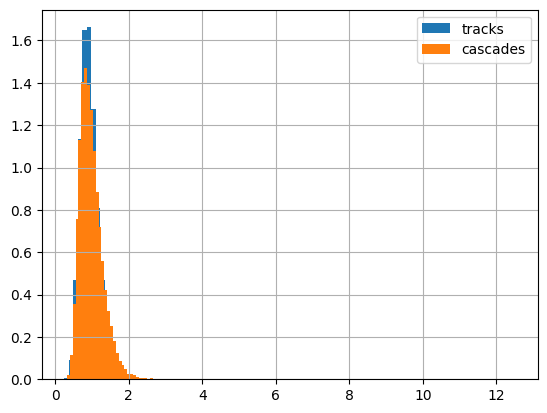

In [8]:
tracks = df[(np.abs(df["pdgid"])==14) & (df["is_cc"]==1)]
cascades = df[(np.abs(df["pdgid"])==12) & (df["is_cc"]==1)]
hist_tracks = tracks["gandalf_shfit_lik_ratio"].hist(bins=100, label = "tracks", density = True)


hist_cascades = cascades["gandalf_shfit_lik_ratio"].hist(bins=100, label = "cascades", density = True)
plt.legend()
plt.show()

In [5]:
mask_reco_track = (df["E.trks.lik[.,0]"]>np.abs(df["E.trks.lik[.,1]"]))
mask_reco_shower = np.invert(mask_reco_track)

mask_true_track = (np.abs(df["pdgid"])==14) & (df["is_cc"]==1)
print("amount of (anti) muon neutrinos with cc is: "+str(np.sum(mask_true_track)))
print("amount of those that are reconstructed as tracks: "+str(np.sum(mask_true_track & mask_reco_track)))

amount of (anti) muon neutrinos with cc is: 248358
amount of those that are reconstructed as tracks: 89004


In [4]:
print(df['pdgid'].value_counts())
print(df['is_cc'].value_counts())

# selection criteria
energy_crit = 20

# centre_x = X_full["jmuon_pos_x"].min() + (X_full['jmuon_pos_x'].max() - X_full['jmuon_pos_x'].min())/2
# centre_y = X_full["jmuon_pos_y"].min() + (X_full['jmuon_pos_y'].max() - X_full['jmuon_pos_y'].min())/2
# approx_r = ((X_full["jmuon_pos_x"].max() - X_full["jmuon_pos_x"].min())/2+(X_full["jmuon_pos_y"].max() - X_full['jmuon_pos_y'].min())/2)/2

# radius_crit = best_params["radius_crit"]
# likelihood_crit = best_params["likelihood_crit"]
# pos_z_crit = best_params["pos_z_crit"]


# threshold_likelihood = np.percentile(X_full['jmuon_likelihood'], likelihood_crit)

mask_z_dir = df['E.trks.dir.z[.,0]'] > 0
mask_energy = (df["E.trks.E[.,0]"] <= energy_crit) | (df["E.trks.E[.,1]"] <= energy_crit)
# mask_radius = np.sqrt((X_full['jmuon_pos_x'] - centre_x)**2 + (X_full['jmuon_pos_y'] - centre_y)**2) < approx_r*radius_crit
# mask_pos_z = X_full['jmuon_pos_z'] > pos_z_crit
# mask_likelihood = X_full['jmuon_likelihood'] > threshold_likelihood
# mask_geometry = mask_pos_z | mask_radius

# mask = mask_likelihood & mask_energy & mask_geometry & mask_z_dir
mask = mask_energy & mask_z_dir

df = df[mask]

# Simulation data
simulation_columns = ['E.mc_trks.dir.z[.,0]', 'E.mc_trks.pos.x[.,0]', 'E.mc_trks.pos.y[.,0]', 'E.mc_trks.pos.z[.,0]', 'T.sum_mc_evt.livetime_DAQ', 
                      'T.sum_mc_evt.weight', 'T.sum_mc_evt.weight_noOsc', 'T.sum_mc_nu.by', 'is_neutrino', 'exposure', 'weight_one_year', 'flux_weight', 
                      'E.frame_index', 'energy', 'pdgid', 'E.run_id', 'E.trigger_counter', 'E.trigger_mask', 'weight_rate', 'w2', 'ngen', 'cos_zenith_true'
                      ,"E_min_gen", "is_cc"]
y_full = df[simulation_columns]
df.drop(columns=simulation_columns, inplace=True)
X_full = df.copy()
df = None

print(y_full['pdgid'].value_counts())


pdgid
 13.0    3328736
-14.0     162188
 14.0     125797
 16.0      98867
-16.0      97324
-12.0      21441
 12.0      17980
Name: count, dtype: int64
is_cc
0.0    3368363
1.0     483970
Name: count, dtype: int64
pdgid
-14.0    95688
 14.0    73515
 13.0    57960
 16.0    54699
-16.0    54559
-12.0    14552
 12.0    12209
Name: count, dtype: int64


## first test rdf, to see feature importance and get baseline

In [4]:
random_state = 42

kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
exp_data = pd.DataFrame()
importances = np.zeros(len(X_full.columns))

for train_index, test_index in kfold.split(X_full):

    X_train, X_test = X_full.iloc[train_index].copy(), X_full.iloc[test_index].copy()
    y_train_compl, y_test_compl = y_full.iloc[train_index].copy(), y_full.iloc[test_index].copy()

    y_train = y_train_compl['is_neutrino']

    clf = RFC(random_state=random_state, verbose = 0, n_jobs=-1)       
    clf.fit(X_train, y_train)
    importances += clf.feature_importances_
    prediction_probabilities = clf.predict_proba(X_test)
    y_pred = np.argmax(prediction_probabilities, axis = 1)

    y_test_compl['muon_score'] = prediction_probabilities[:,0]
    y_test_compl['prediction'] = y_pred
    y_test_compl["E.trks.E[.,0]"] = X_test["E.trks.E[.,0]"]
    y_test_compl["E.trks.E[.,1]"] = X_test["E.trks.E[.,1]"]
    # y_test_compl[""] = X_test['jmuon_E']

    exp_data = pd.concat([exp_data, y_test_compl])

importances = importances/5


NameError: name 'X_full' is not defined

In [2]:
n_features = 15
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_full.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_full.columns[indices[f]], importances[indices[f]]))
# Get feature importances from the RandomForestClassifier


# Get column names from X_train
column_names = X_full.columns
# Rearrange column names based on sorted feature importances
sorted_column_names = column_names[indices[:n_features]]
sorted_importances = importances[indices[:n_features]]

# Create a bar plot
plt.figure(figsize=(10, 7))
plt.barh(range(n_features), sorted_importances)
plt.yticks(range(n_features), sorted_column_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances Top {} Features'.format(n_features))
plt.show()


NameError: name 'np' is not defined

## determine neutrino efficiency

In [19]:
def muon_contamination(muons, neutrs, start= 0.001, stop= 1, n= 1000):
    
    score_thresholds = np.linspace(start,stop,n)
    muon_contamination_percs = []


    for threshold in score_thresholds:
        
        rem_neutrs = np.sum(neutrs[neutrs['muon_score']<=threshold]["flux_weight"])
        rem_muons = np.sum(muons[muons['muon_score']<=threshold]["weight_one_year"])
        muon_contamination_perc = rem_muons/(rem_muons+rem_neutrs)*100
        muon_contamination_percs.append(muon_contamination_perc)

    return np.array(muon_contamination_percs)

def neutrino_efficiency(neutrs, start= 0.001, stop= 1, n= 1000):

    score_thresholds = np.linspace(start,stop,n)
    neutrino_efficiency_percs = []
    total_neutrinos = np.sum(neutrs["flux_weight"])
    for threshold in score_thresholds:
        
        rem_neutrs = np.sum(neutrs[neutrs['muon_score']<=threshold]["flux_weight"])
        neutrino_efficiency_perc = rem_neutrs/total_neutrinos*100
        neutrino_efficiency_percs.append(neutrino_efficiency_perc)

    return np.array(neutrino_efficiency_percs)

In [20]:
muons = exp_data[exp_data['is_neutrino'] == 0]
neutrinos = exp_data[exp_data['is_neutrino'] == 1]


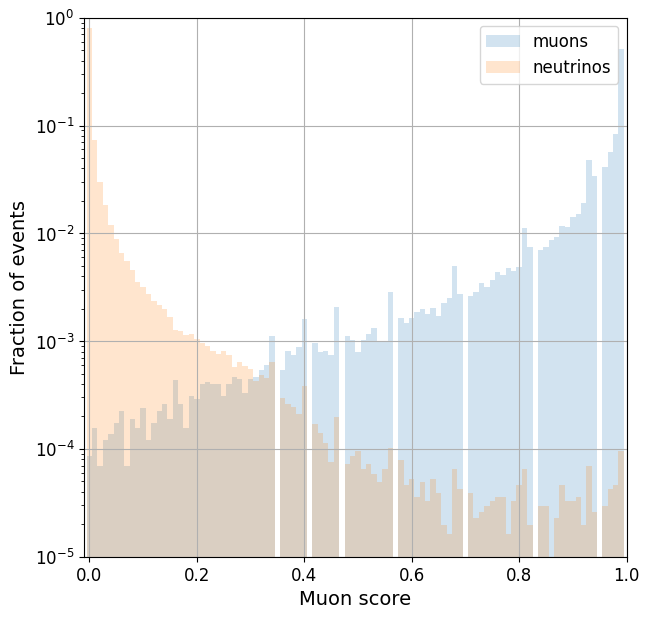

In [21]:
hist_muon_scores_muons, score_bins = np.histogram(muons['muon_score'], bins = 100, range = (0,1))
hist_muon_scores_neutrs = np.histogram(neutrinos['muon_score'], bins = 100, range = (0,1))[0]

frac_muon_score_muons = hist_muon_scores_muons/np.sum(hist_muon_scores_muons)
frac_muon_score_neutrs = hist_muon_scores_neutrs/np.sum(hist_muon_scores_neutrs)
min_y = min(np.min(frac_muon_score_muons), np.min(frac_muon_score_neutrs))

plt.figure()
plt.yscale('log')
plt.bar(score_bins[:-1], frac_muon_score_muons, width = 1/100, alpha = 0.2, label = "muons")
plt.bar(score_bins[:-1], frac_muon_score_neutrs, width = 1/100, alpha = 0.2, label = "neutrinos")
plt.ylabel("Fraction of events")
plt.xlabel("Muon score")
plt.ylim(10**-5, 1)
plt.xlim(-0.01,1)
plt.grid()
plt.legend()
plt.show()



## new figure of merit
Follow true oscillation analysis cutoffs for muon_score, track_score etc. to create the final data for which to determine the desired neutrino efficiency. https://wiki.km3net.de/index.php/Neutrino_Oscillations/Oscillation_Analysis_ORCA6/10/11 .


In [27]:
total_E_mask_neutrinos = neutrinos['energy'] <= 20
total_E_mask_muons = muons["energy"] <= 20

low_E_mask_neutrinos = neutrinos['energy'] <= 10
low_E_mask_muons = muons["energy"] <= 10

high_E_mask_neutrinos = (neutrinos['energy'] <= 20) & (neutrinos['energy'] > 10)
high_E_mask_muons = (muons["energy"] <= 20) & (muons["energy"] > 10)

low_E_reco_mask_muons = (muons['E.trks.E[.,0]'] <= 10) | (muons['E.trks.E[.,1]'] <= 10)
low_E_reco_mask_neutrinos = (neutrinos['E.trks.E[.,0]'] <= 10) | (neutrinos['E.trks.E[.,1]'] <= 10)

high_E_reco_mask_neutrinos = ((neutrinos['E.trks.E[.,0]'] <= 20) & (neutrinos['E.trks.E[.,0]'] > 10)) | ((neutrinos['E.trks.E[.,1]'] <= 20) & (neutrinos['E.trks.E[.,1]'] > 10))
high_E_reco_mask_muons = ((muons['E.trks.E[.,0]'] <= 20) & (muons['E.trks.E[.,0]'] > 10)) | ((muons['E.trks.E[.,1]'] <= 20) & (muons['E.trks.E[.,1]'] > 10))

print("amount of neutrino points both in low and high reco brackets = {}".format(np.sum(low_E_reco_mask_neutrinos & high_E_reco_mask_neutrinos)))

print("amount of neutrino data points in low reco bracket = {}".format(np.sum(low_E_reco_mask_neutrinos)))
print("amount of neutrino data points in high reco bracket = {}".format(np.sum(high_E_reco_mask_neutrinos)))

print("amount of desired neutrino data points in low reco bracket = {}".format(np.sum(low_E_reco_mask_neutrinos & total_E_mask_neutrinos)))
print("amount of desired neutrino data points in high reco bracket = {}".format(np.sum(high_E_reco_mask_neutrinos & total_E_mask_neutrinos)))
print("total amount of desired neutrino datapoints = {}".format(np.sum(total_E_mask_neutrinos)))

n_desired_neutrinos_low_reco = np.sum(neutrinos[low_E_reco_mask_neutrinos & total_E_mask_neutrinos]["flux_weight"])
n_desired_neutrinos_high_reco = np.sum(neutrinos[high_E_reco_mask_neutrinos & total_E_mask_neutrinos]["flux_weight"])
n_desired_neutrinos_total = np.sum(neutrinos[total_E_mask_neutrinos]["flux_weight"])
print("n desired neutrinos low reco: ", n_desired_neutrinos_low_reco)
print("n desired neutrinos high reco: ", n_desired_neutrinos_high_reco)
print("n desired neutrinos total: ", n_desired_neutrinos_total)

amount of neutrino points both in low and high reco brackets = 84632
amount of neutrino data points in low reco bracket = 266063
amount of neutrino data points in high reco bracket = 123791
amount of desired neutrino data points in low reco bracket = 182233
amount of desired neutrino data points in high reco bracket = 66698
total amount of desired neutrino datapoints = 190917
n desired neutrinos low reco:  3691.891716421827
n desired neutrinos high reco:  754.0883077112785
n desired neutrinos total:  3711.688832499777


Need to really make this plot more straightforward and adaptable.

Amount of muons in low reco bracket is:  73314.14810678014
Amount of neutrinos in low reco bracket is:  3700.227583836464
Amount of muons in high reco bracket is:  79283.59993261239
Amount of neutrinos in high reco bracket is:  760.451961932571


/tmp/ipykernel_107817/3839714258.py:84: RuntimeWarning: invalid value encountered in scalar divide
  muon_contamination_percentages_low.append(n_remaining_muons_low_reco/(n_remaining_muons_low_reco + n_remaining_neutrinos_low_reco)*100)
/tmp/ipykernel_107817/3839714258.py:85: RuntimeWarning: invalid value encountered in scalar divide
  muon_contamination_percentages_high.append(n_remaining_muons_high_reco/(n_remaining_muons_high_reco + n_remaining_neutrinos_high_reco)*100)
/tmp/ipykernel_107817/3839714258.py:86: RuntimeWarning: invalid value encountered in scalar divide
  muon_contamination_percentages_total.append(n_remaining_muons_total/(n_remaining_muons_total + n_remaining_neutrinos_total)*100)
/tmp/ipykernel_107817/3839714258.py:88: RuntimeWarning: invalid value encountered in scalar divide
  contamination_percentages_low.append((n_remaining_muons_low_reco+n_remaining_neutrinos_low_reco - n_remaining_desired_neutrinos_low_reco)/(n_remaining_muons_low_reco + n_remaining_neutrinos_l

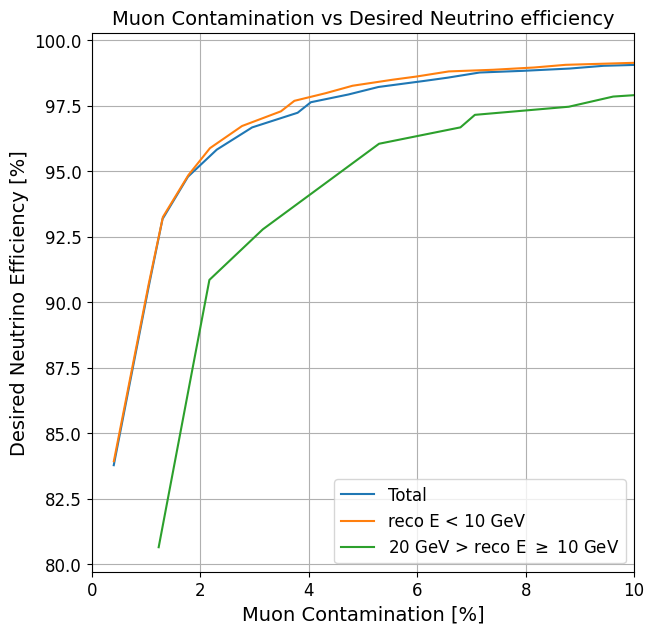

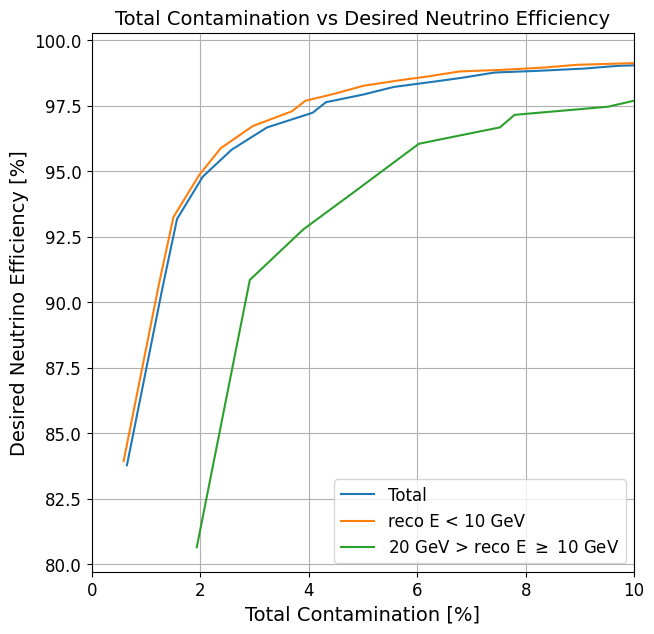

In [30]:
"""
Needs to quantify the amount of usefull/desired neutrinos that are available after the entire process.
Will need to be weighted according to the flux of neutrinos at the different energies/ for different neutrinos.
Roughest estimate would be to take the neutrino efficiency but take out the neutrinos that have a true energy higher than 20 GeV.
Could also filter out neutrinos that are not truly upgoing.
Should try these things out first.

But now how to visualize this?
Simplest is just a number.

Should i constrain on true energy and dir or reconstructed?

"""

make_plot = True
desired_neutrinos_efficiency_low = []
desired_neutrinos_efficiency_high = []
desired_neutrinos_efficiency_total = []

muon_contamination_percentages_low = []
muon_contamination_percentages_high = []
muon_contamination_percentages_total = []

contamination_percentages_low = []
contamination_percentages_high = []
contamination_percentages_total = []

total_E_mask_neutrinos = neutrinos['energy'] <= 20
total_E_mask_muons = muons["energy"] <= 20

low_E_mask_neutrinos = neutrinos['energy'] <= 10
low_E_mask_muons = muons["energy"] <= 10

high_E_mask_neutrinos = (neutrinos['energy'] <= 20) & (neutrinos['energy'] > 10)
high_E_mask_muons = (muons["energy"] <= 20) & (muons["energy"] > 10)

low_E_reco_mask_muons = (muons['E.trks.E[.,0]'] <= 10) | (muons['E.trks.E[.,1]'] <= 10)
low_E_reco_mask_neutrinos = (neutrinos['E.trks.E[.,0]'] <= 10) | (neutrinos['E.trks.E[.,1]'] <= 10)
print("Amount of muons in low reco bracket is: ", np.sum(muons[low_E_reco_mask_muons]["weight_one_year"]))
print("Amount of neutrinos in low reco bracket is: ", np.sum(neutrinos[low_E_reco_mask_neutrinos]["flux_weight"]))

high_E_reco_mask_neutrinos = ((neutrinos['E.trks.E[.,0]'] <= 20) & (neutrinos['E.trks.E[.,0]'] > 10)) | ((neutrinos['E.trks.E[.,1]'] <= 20) & (neutrinos['E.trks.E[.,1]'] > 10))
high_E_reco_mask_muons = ((muons['E.trks.E[.,0]'] <= 20) & (muons['E.trks.E[.,0]'] > 10)) | ((muons['E.trks.E[.,1]'] <= 20) & (muons['E.trks.E[.,1]'] > 10))
print("Amount of muons in high reco bracket is: ", np.sum(muons[high_E_reco_mask_muons]["weight_one_year"]))
print("Amount of neutrinos in high reco bracket is: ", np.sum(neutrinos[high_E_reco_mask_neutrinos]["flux_weight"]))

n_desired_neutrinos_low_reco = np.sum(neutrinos[low_E_reco_mask_neutrinos & total_E_mask_neutrinos]["flux_weight"])
n_desired_neutrinos_high_reco = np.sum(neutrinos[high_E_reco_mask_neutrinos & total_E_mask_neutrinos]["flux_weight"])

n_desired_neutrinos_low_true = np.sum(neutrinos[low_E_mask_neutrinos]["weight_one_year"])
n_desired_neutrinos_high_true = np.sum(neutrinos[high_E_mask_neutrinos]["weight_one_year"])


n_desired_neutrinos_total = np.sum(neutrinos[total_E_mask_neutrinos]["flux_weight"])


if make_plot:
    for muon_score_threshold in np.linspace(0,0.2,100):

        neutrino_score_mask = neutrinos['muon_score'] < muon_score_threshold
        muon_score_mask = muons['muon_score'] < muon_score_threshold

        n_remaining_muons_low_reco = np.sum(muons[muon_score_mask & low_E_reco_mask_muons]["weight_one_year"])
        n_remaining_muons_high_reco = np.sum(muons[muon_score_mask & high_E_reco_mask_muons]["weight_one_year"])
        n_remaining_muons_total = np.sum(muons[muon_score_mask]["weight_one_year"])

        n_remaining_neutrinos_low_reco = np.sum(neutrinos[neutrino_score_mask & low_E_reco_mask_neutrinos]["flux_weight"])
        n_remaining_neutrinos_high_reco = np.sum(neutrinos[neutrino_score_mask & high_E_reco_mask_neutrinos]["flux_weight"])
        n_remaining_neutrinos_total = np.sum(neutrinos[neutrino_score_mask]["flux_weight"])

        n_remaining_desired_neutrinos_low_reco = np.sum(neutrinos[neutrino_score_mask & low_E_reco_mask_neutrinos & total_E_mask_neutrinos]["flux_weight"])
        n_remaining_desired_neutrinos_high_reco = np.sum(neutrinos[neutrino_score_mask & high_E_reco_mask_neutrinos & total_E_mask_neutrinos]["flux_weight"])
        n_remaining_desired_neutrinos_total = np.sum(neutrinos[neutrino_score_mask & total_E_mask_neutrinos]["flux_weight"])



        # print("n remaining neutrinos: ", n_remaining_neutrinos)
        # print("n remaining desired neutrinos: ", n_remaining_desired_neutrinos)
        
        desired_neutrinos_efficiency_low.append(n_remaining_desired_neutrinos_low_reco/n_desired_neutrinos_low_reco*100)
        desired_neutrinos_efficiency_high.append(n_remaining_desired_neutrinos_high_reco/n_desired_neutrinos_high_reco*100)
        desired_neutrinos_efficiency_total.append(n_remaining_desired_neutrinos_total/n_desired_neutrinos_total*100)

        muon_contamination_percentages_low.append(n_remaining_muons_low_reco/(n_remaining_muons_low_reco + n_remaining_neutrinos_low_reco)*100)
        muon_contamination_percentages_high.append(n_remaining_muons_high_reco/(n_remaining_muons_high_reco + n_remaining_neutrinos_high_reco)*100)
        muon_contamination_percentages_total.append(n_remaining_muons_total/(n_remaining_muons_total + n_remaining_neutrinos_total)*100)

        contamination_percentages_low.append((n_remaining_muons_low_reco+n_remaining_neutrinos_low_reco - n_remaining_desired_neutrinos_low_reco)/(n_remaining_muons_low_reco + n_remaining_neutrinos_low_reco)*100)
        contamination_percentages_high.append((n_remaining_muons_high_reco+n_remaining_neutrinos_high_reco - n_remaining_desired_neutrinos_high_reco)/(n_remaining_muons_high_reco + n_remaining_neutrinos_high_reco)*100)
        contamination_percentages_total.append((n_remaining_muons_total+n_remaining_neutrinos_total - n_remaining_desired_neutrinos_total)/(n_remaining_muons_total + n_remaining_neutrinos_total)*100)

        # muon_contamination_remaining = n_muons_remaining/(n_muons_remaining + n_remaining_desired_neutrinos)
        # print("muon contamination remaining: ", muon_contatimination_remaining)

    plt.plot(muon_contamination_percentages_total, desired_neutrinos_efficiency_total, label = "Total")
    plt.plot(muon_contamination_percentages_low, desired_neutrinos_efficiency_low, label = "reco E < 10 GeV")
    plt.plot(muon_contamination_percentages_high, desired_neutrinos_efficiency_high, label = "20 GeV > reco E $\geq$ 10 GeV")
    plt.xlabel("Muon Contamination [%]")
    plt.ylabel("Desired Neutrino Efficiency [%]")
    plt.grid()
    plt.xlim(0,10)
    plt.title("Muon Contamination vs Desired Neutrino efficiency")
    plt.legend()
    plt.show()

    plt.plot(contamination_percentages_total, desired_neutrinos_efficiency_total, label = "Total")
    plt.plot(contamination_percentages_low, desired_neutrinos_efficiency_low, label = "reco E < 10 GeV")
    plt.plot(contamination_percentages_high, desired_neutrinos_efficiency_high, label = "20 GeV > reco E $\geq$ 10 GeV")
    plt.xlabel("Total Contamination [%]")
    plt.ylabel("Desired Neutrino Efficiency [%]")
    plt.grid()
    plt.xlim(0,10)
    plt.title("Total Contamination vs Desired Neutrino Efficiency")
    # plt.ylim(70,100)
    plt.legend()
    plt.show()




In [13]:

print(f"total desired neutrino efficiency at {contamination_percentages_total[np.argmin(np.abs(np.nan_to_num(contamination_percentages_total)-2))]}% total contamination is: ", desired_neutrinos_efficiency_total[np.argmin(np.abs(np.nan_to_num(contamination_percentages_total)-2))])

total desired neutrino efficiency at 2.0475908283887176% total contamination is:  94.78727170801045


## test scores and distributions wrong/right

Mean Test Score:  0.9132958323831998
Std Test Score:  0.0037851958240728662
The prediction difficulty for type  muon  is 0.022973550540427913 +- 0.002200989894401434
The prediction difficulty for type  neutrino_anti-elec-CC  is 0.12425970478282958 +- 0.01653109774836573
The prediction difficulty for type  neutrino_anti-muon-NC  is 0.17604455671308897 +- 0.027708240483613956
The prediction difficulty for type  neutrino_muon-CC  is 0.16272223455339357 +- 0.01445261872464011
The prediction difficulty for type  neutrino_muon-NC  is 0.18013328819668212 +- 0.0260179287797929
The prediction difficulty for type  neutrino_tau-CC  is 0.1522236415775128 +- 0.029549586837580414
The prediction difficulty for type  neutrino_anti-tau-CC  is 0.11576487552059937 +- 0.03312136134936172
The prediction difficulty for type  neutrino_anti-muon-CC  is 0.1575994740948649 +- 0.02873706792211759
The prediction difficulty for type  neutrino_elec-CC  is 0.13635559756364712 +- 0.022116461908415833


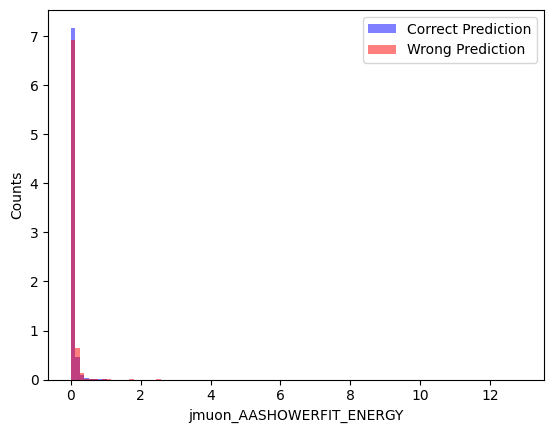

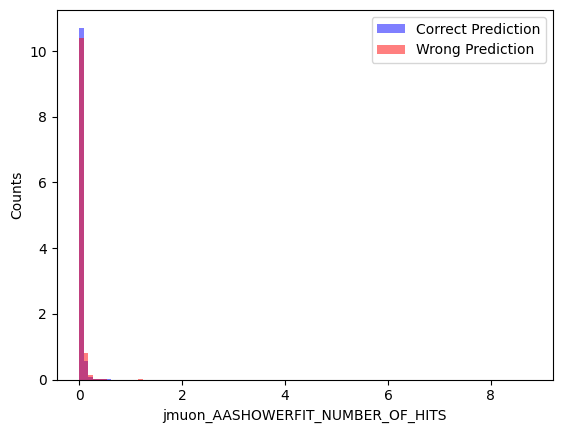

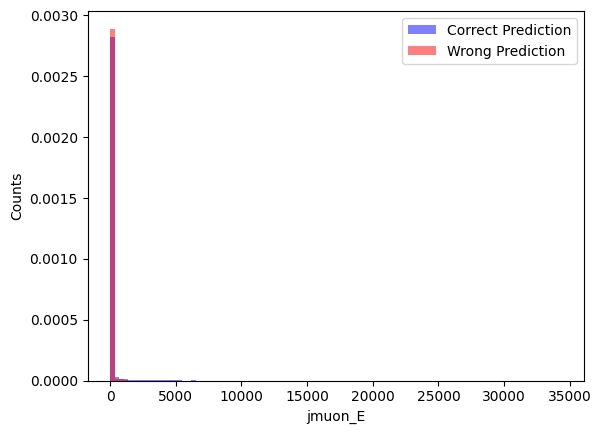

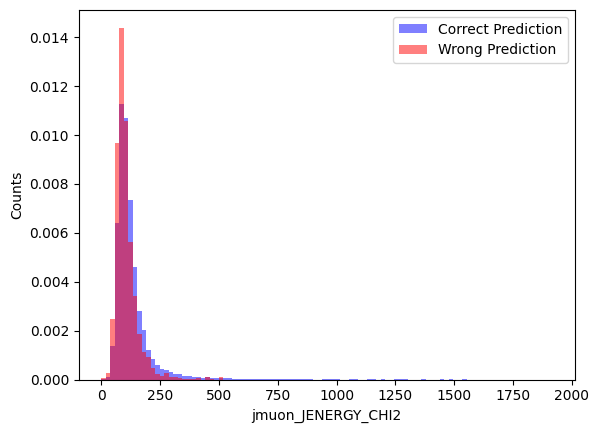

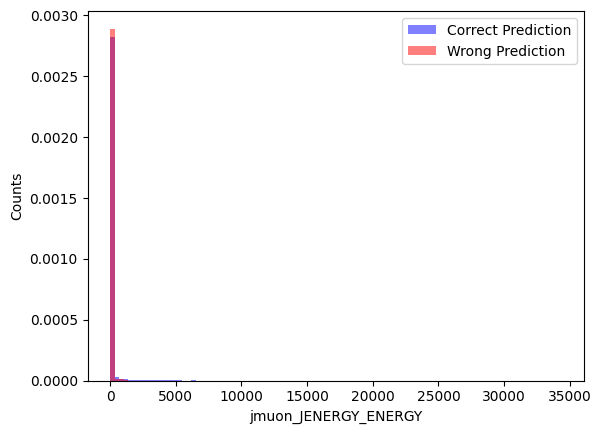

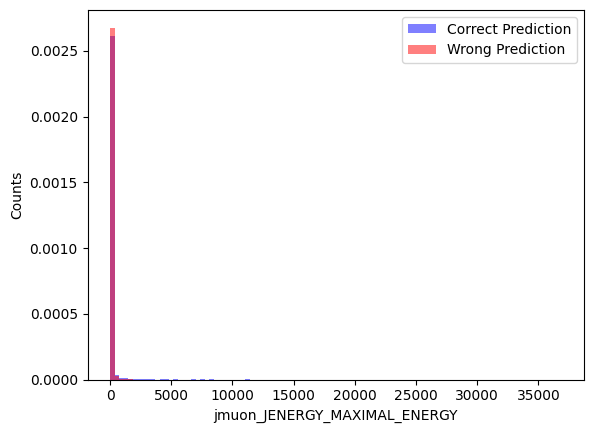

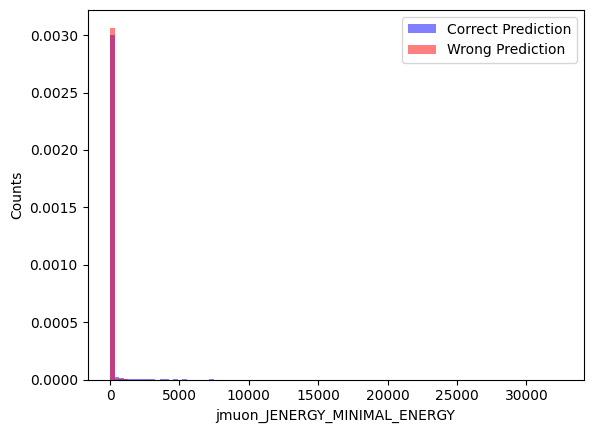

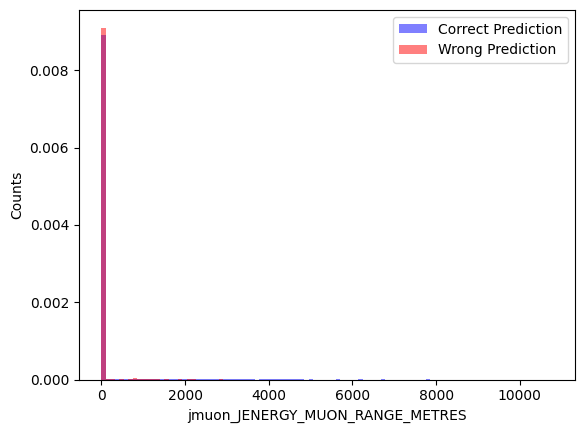

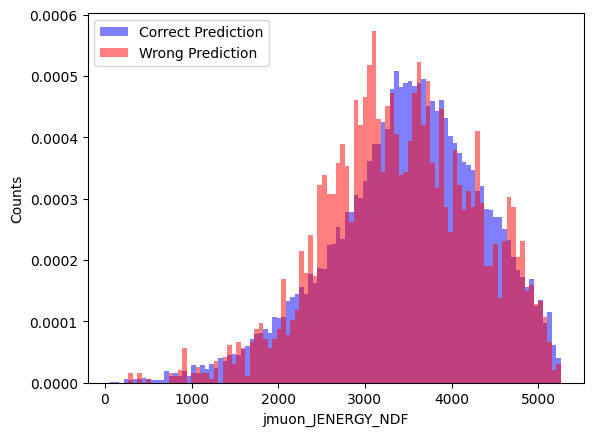

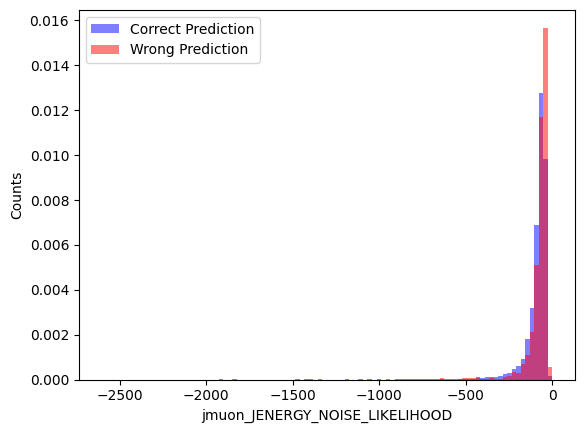

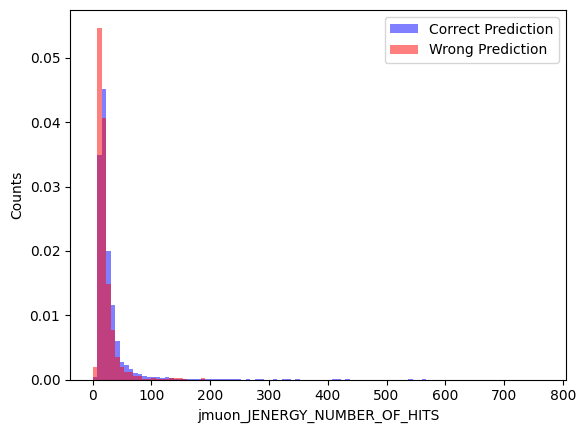

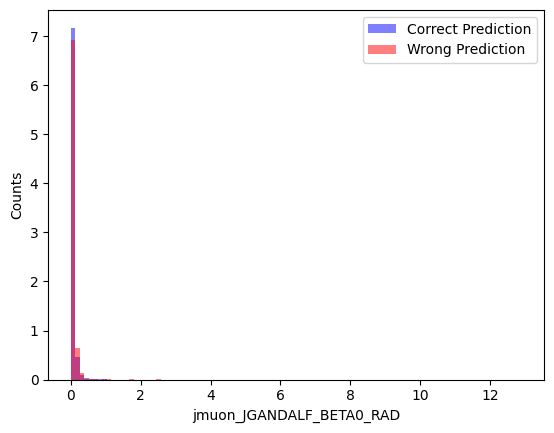

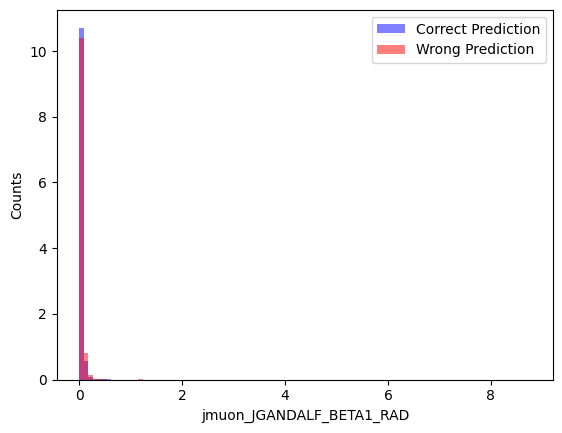

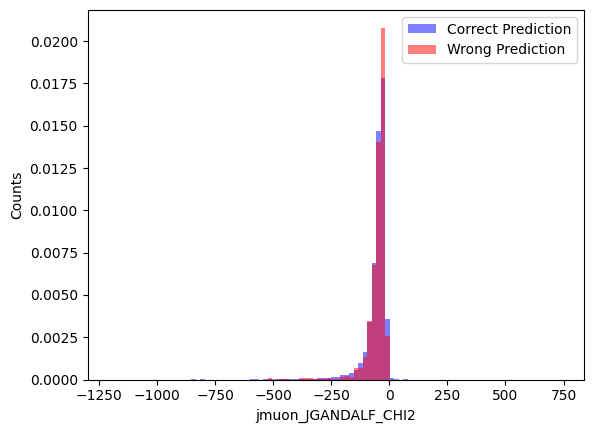

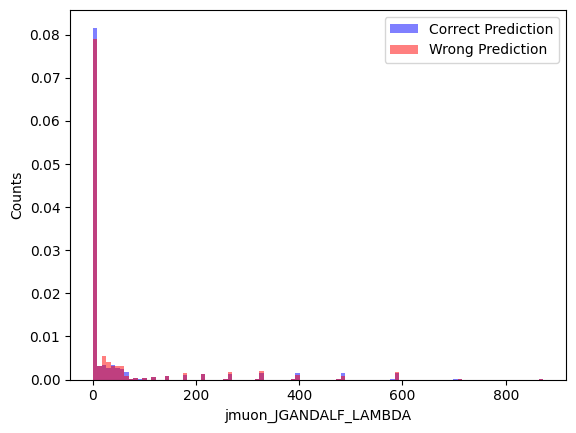

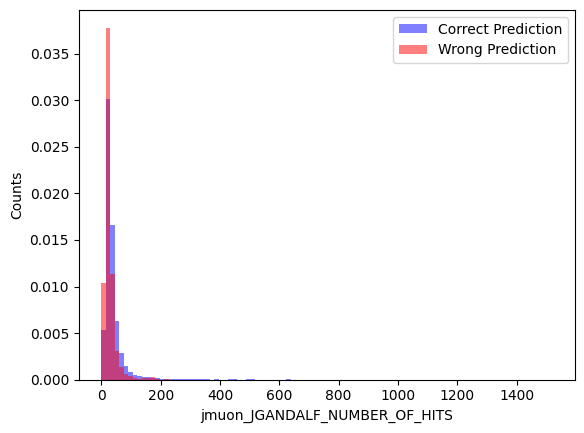

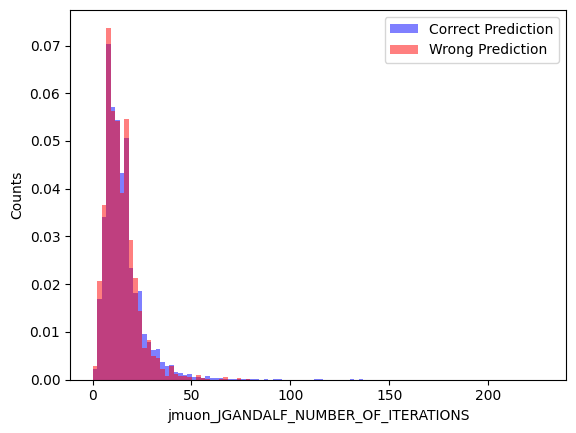

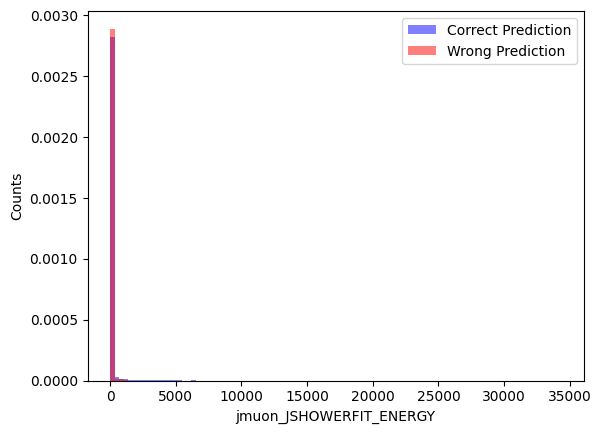

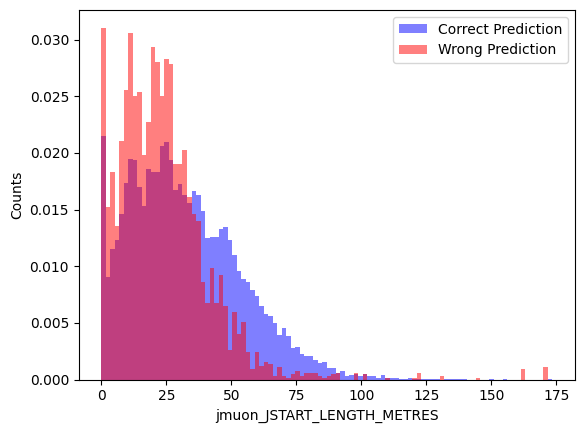

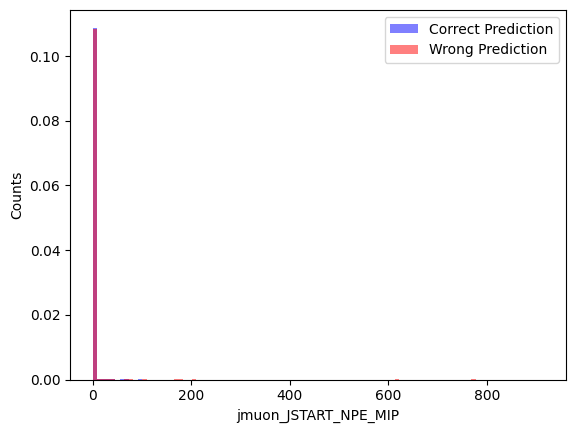

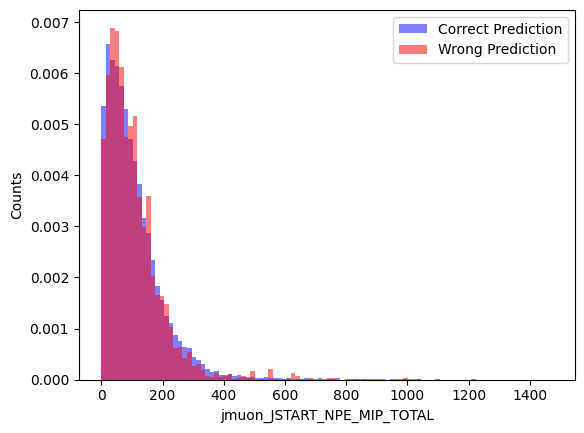

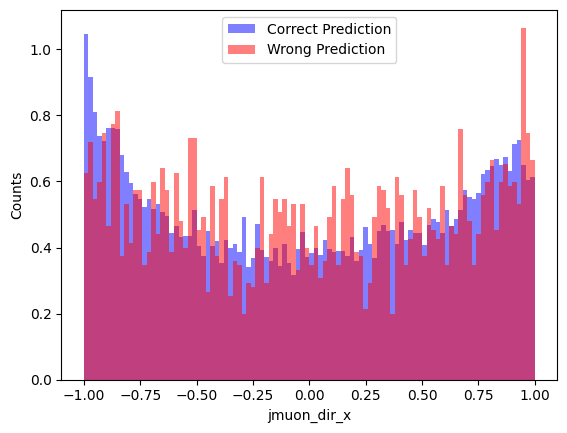

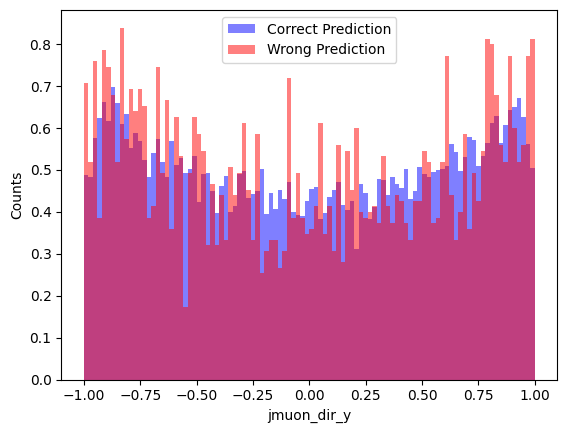

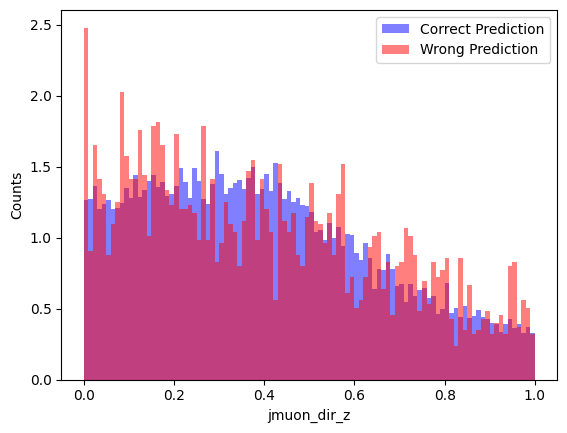

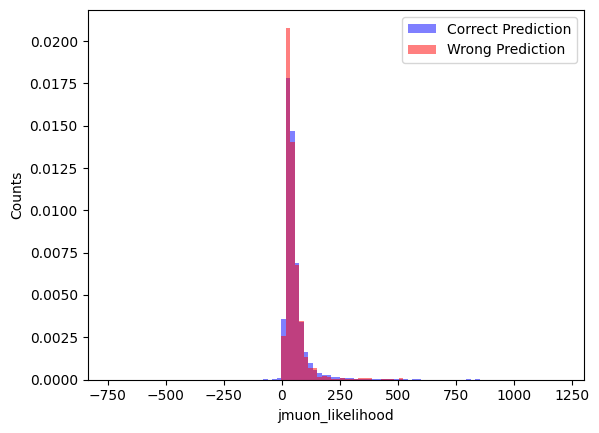

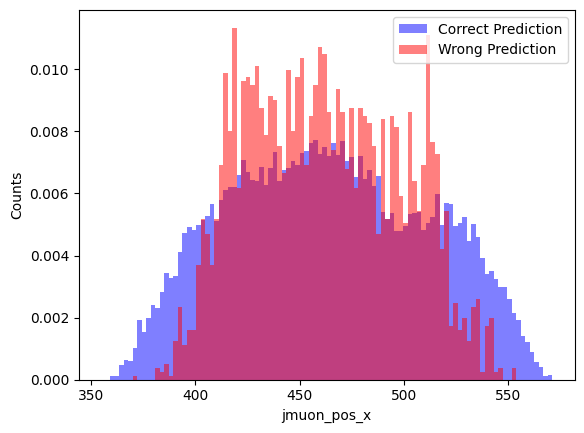

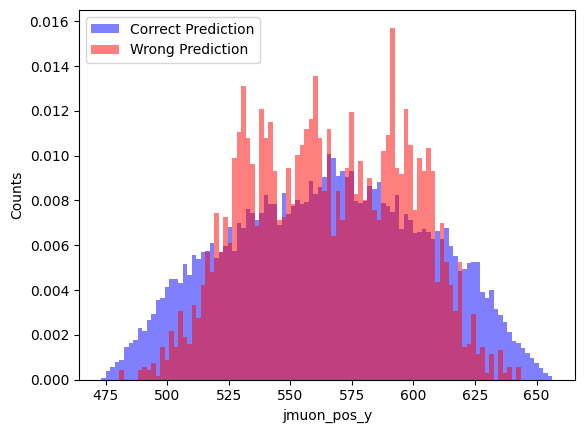

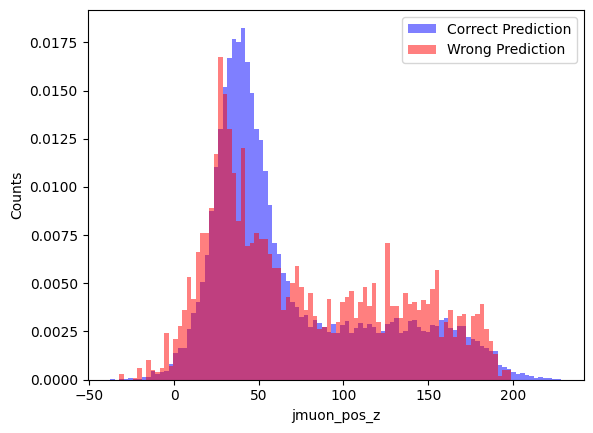

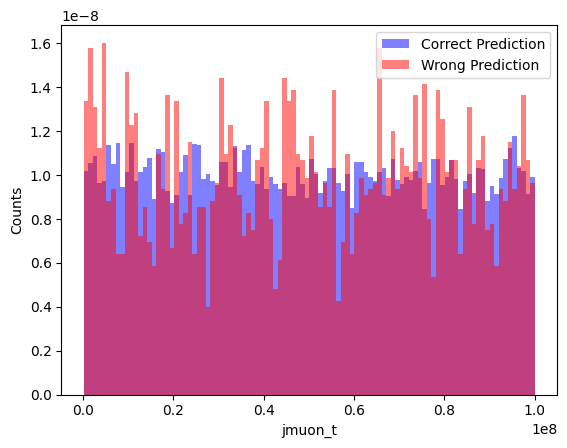

In [51]:
# test_scores, df_prediction_difficulties, hists_true, hists_false, columns, bins = experiment(paths_atm_muon, paths_atm_neutr, neutr_types, 50)
print("Mean Test Score: ", np.mean(test_scores))
print("Std Test Score: ", np.std(test_scores))

avg_prediction_difficulties = df_prediction_difficulties.mean()
std_prediction_difficulties = df_prediction_difficulties.std()
# print("The average prediction difficulty (fraction of wrong predictions) per type is:")
# print(avg_prediction_difficulties)
for column in df_prediction_difficulties.columns:
    print("The prediction difficulty for type ", column, " is", avg_prediction_difficulties[column], "+-", std_prediction_difficulties[column])

for i, column in enumerate(X.columns):
    plt.figure()
    plt.hist(bins[i][:-1], bins=bins[i], weights = hists_true[i], alpha=0.5, density= True, label='Correct Prediction', color='blue')
    plt.hist(bins[i][:-1], bins=bins[i], weights= hists_false[i], alpha=0.5, density= True, label='Wrong Prediction', color='red')
    plt.xlabel(column)
    plt.ylabel('Counts')
    plt.legend()
    plt.show()